# 20. Projekt końcowy

In [2]:
# data manipulation
import numpy as np
import pandas as pd
import datetime as dt
import time
from math import sqrt
from tqdm import tqdm
import holidays

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature selection
from sklearn.feature_selection import RFECV

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# interpretowalność modelu
import shap
shap.initjs()

# zapisanie modelu
import joblib

# settings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 20.1. Zrozumienie uwarunkowań biznesowych

# 20.2. Zrozumienie danych

In [3]:
dataframe = pd.read_csv('bikerides_day.csv')
dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe

,Date,Volume,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8
...,...,...,...,...
1268,2020-05-16,2484.0,0.0,6.6
1269,2020-05-17,1509.0,0.0,9.1
1270,2020-05-18,5775.0,0.0,9.3
1271,2020-05-19,6741.0,0.0,9.7


### Czy są wartości brakujące?

In [4]:
dataframe.isnull().mean()*100

Date      0.0
Volume    0.0
Rain      0.0
Temp      0.0
dtype: float64

### Czy są duplikaty dla daty?

In [5]:
dataframe.loc[dataframe.duplicated(subset='Date', keep=False), :]

,Date,Volume,Rain,Temp


### Czy daty są posortowane?

In [6]:
(dataframe['Date'] == dataframe['Date'].sort_values()).all()

True

### Czy są wszystkie daty?

In [7]:
pd.date_range(start=dataframe['Date'].min(), 
            end=dataframe['Date'].max()).difference(dataframe['Date'])

DatetimeIndex(['2017-10-16', '2019-01-14', '2019-06-07', '2019-06-08',
               '2019-06-09', '2019-06-10', '2019-08-14', '2019-08-15'],
              dtype='datetime64[ns]', freq=None)

In [8]:
dataframe.loc[dataframe['Date']=='2017-10-16',:]

,Date,Volume,Rain,Temp


In [9]:
dataframe.loc[dataframe['Date']=='2017-10-15',:]

,Date,Volume,Rain,Temp
332,2017-10-15,843.0,0.0,9.6


### Jaki jest rozkład naszych danych?

In [11]:
dataframe.describe()

,Volume,Rain,Temp
count,1273.000000,1273.000000,1273.000000
mean,2609.344855,1.945640,6.783975
std,1968.623825,4.505151,7.726084
min,63.000000,0.000000,-11.400000
25%,1185.000000,0.000000,0.700000
50%,2073.000000,0.000000,5.500000
75%,3801.000000,1.400000,13.400000
max,8679.000000,39.500000,25.900000


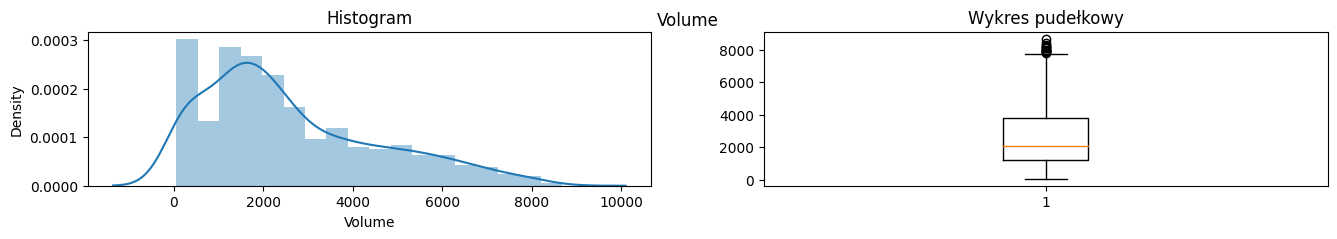

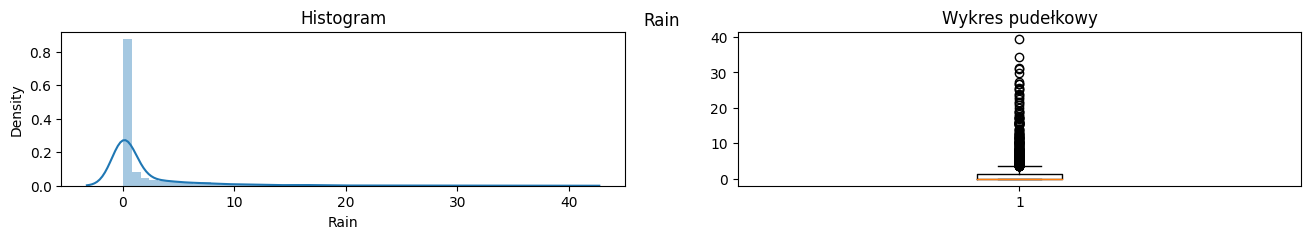

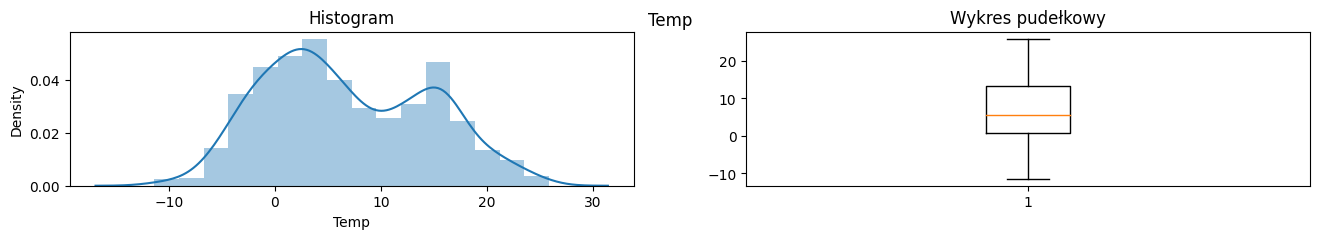

In [12]:
for variable in dataframe.select_dtypes(include=np.number).columns:
    fig = plt.figure(figsize=(16, 2))
    fig.suptitle(variable, fontsize=12)
    plt.subplot(121)
    sns.distplot(dataframe[variable], kde=True, rug=False)
    plt.title('Histogram')
    plt.subplot(122)
    plt.boxplot(dataframe[variable])
    plt.title('Wykres pudełkowy')
    plt.show()

### Jak wygląda liczba wypożyczonych rowerów w czasie?

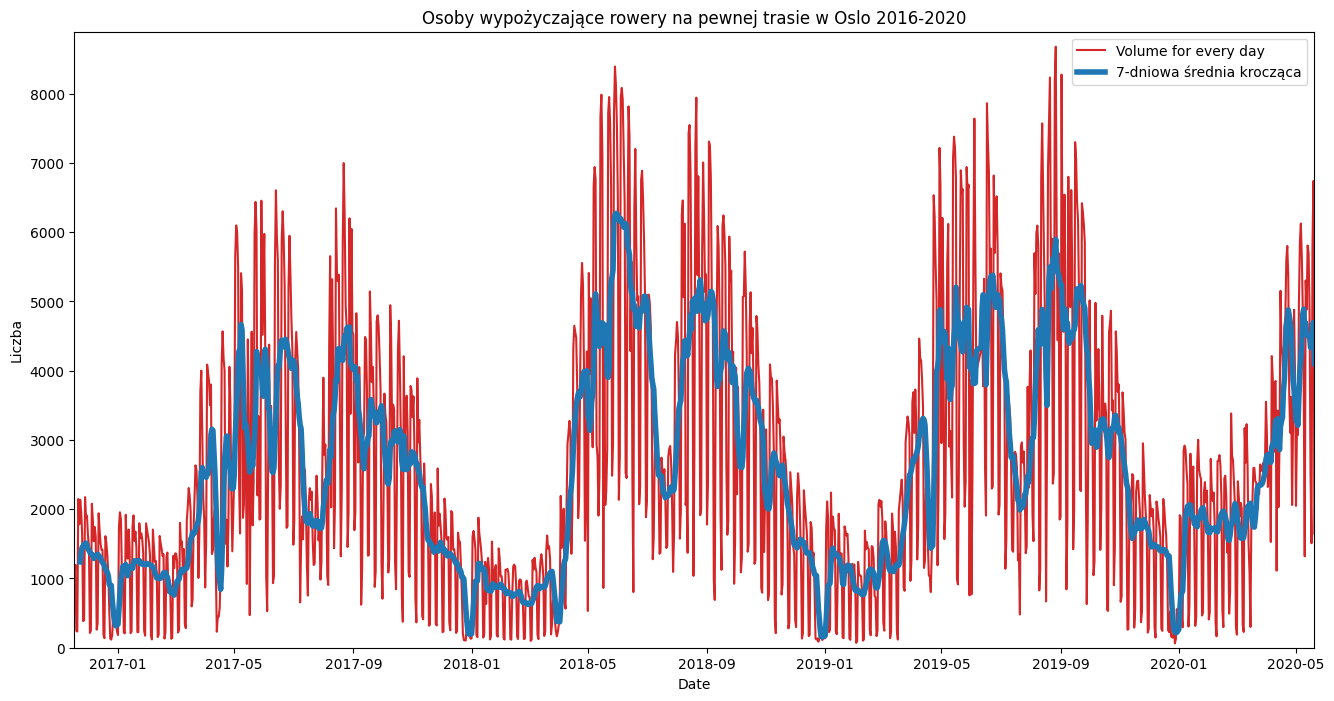

In [13]:
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(dataframe['Date'], dataframe['Volume'],
         color='tab:red', label='Volume for every day')
plt.plot(dataframe['Date'], dataframe['Volume'].rolling(7).mean(),
         color='tab:blue', linewidth=4, label='7-dniowa średnia krocząca')
plt.title('Osoby wypożyczające rowery na pewnej trasie w Oslo 2016-2020')
plt.xlabel('Date')
plt.ylabel('Liczba')
plt.xlim([dataframe['Date'].min(), dataframe['Date'].max()])
plt.ylim([0, dataframe['Volume'].max()*1.025])
plt.legend(loc='upper right')
plt.show()

In [14]:
full_years = dataframe.loc[(dataframe['Date'] >= '2017-01-01') & (dataframe['Date'] < '2020-01-01')].copy()
full_years['year'] = [d.year for d in full_years['Date']]
full_years['month'] = [d.strftime('%b') for d in full_years['Date']]
full_years['weekday'] = [d.strftime('%A') for d in full_years['Date']]
full_years

,Date,Volume,Rain,Temp,year,month,weekday
45,2017-01-01,183.0,0.0,1.1,2017,Jan,Sunday
46,2017-01-02,1752.0,0.0,-2.8,2017,Jan,Monday
47,2017-01-03,1956.0,0.0,-2.5,2017,Jan,Tuesday
48,2017-01-04,1854.0,0.0,-3.1,2017,Jan,Wednesday
49,2017-01-05,1113.0,0.0,-10.1,2017,Jan,Thursday
...,...,...,...,...,...,...,...
1127,2019-12-27,342.0,0.0,-4.9,2019,Dec,Friday
1128,2019-12-28,63.0,0.0,-1.2,2019,Dec,Saturday
1129,2019-12-29,126.0,5.9,4.4,2019,Dec,Sunday
1130,2019-12-30,558.0,0.0,5.5,2019,Dec,Monday


In [15]:
full_years_monthly = full_years.groupby(['year', 'month'])[['Volume']].mean()
full_years_monthly.reset_index(inplace=True)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

full_years_monthly['month'] = pd.Categorical(full_years_monthly['month'], categories=months, ordered=True)
full_years_monthly.sort_values(by=['year', 'month'], inplace=True)
display(full_years_monthly.head(3))
display(full_years_monthly.tail(3))

,year,month,Volume
4,2017,Jan,1202.225806
3,2017,Feb,980.250000
7,2017,Mar,1703.419355


,year,month,Volume
34,2019,Oct,3204.967742
33,2019,Nov,1852.500000
26,2019,Dec,1035.580645


2017
2018
2019


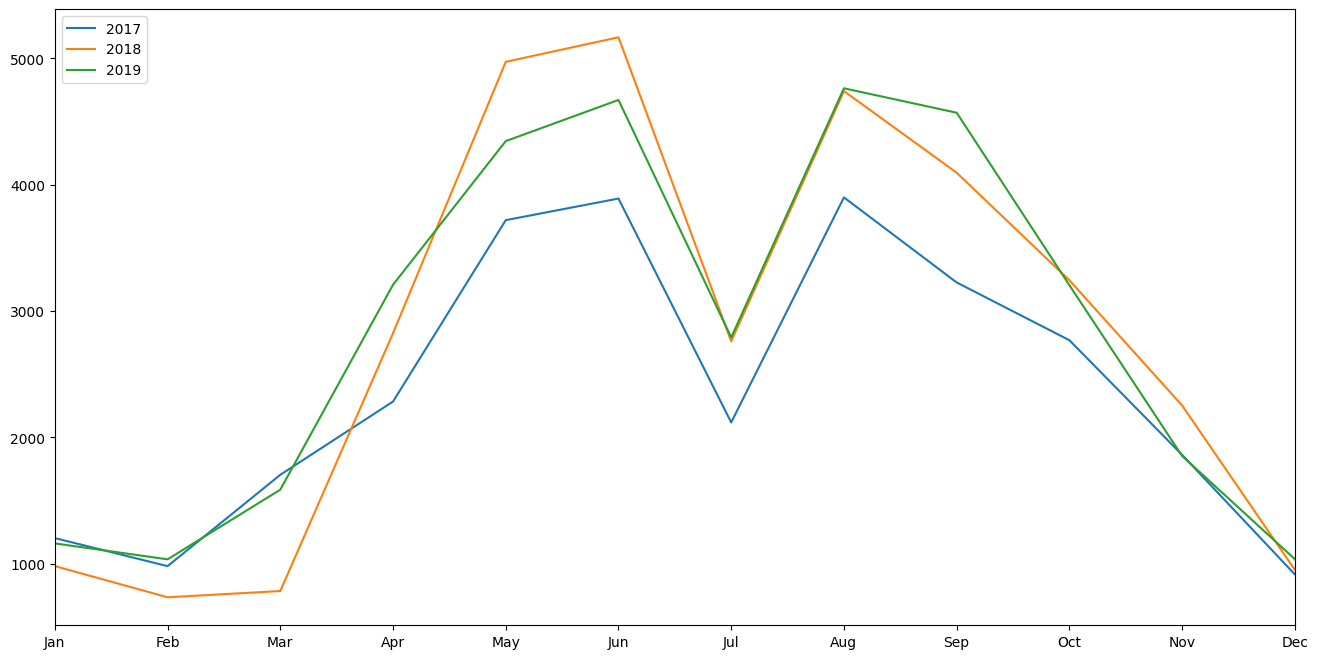

In [16]:
plt.figure(figsize=(16, 8), dpi=100)
for year in full_years['year'].unique():
    plt.plot(full_years_monthly.loc[full_years_monthly['year']==year, 'month'],
             full_years_monthly.loc[full_years_monthly['year']==year, 'Volume'], label=year)
    print(year)
plt.legend(loc='upper left')
plt.xlim(['Jan', 'Dec'])
plt.show()

- Rok (trend)
- Miesiąc (sezonowość)
- Dzień tygodnia (sezonowość)

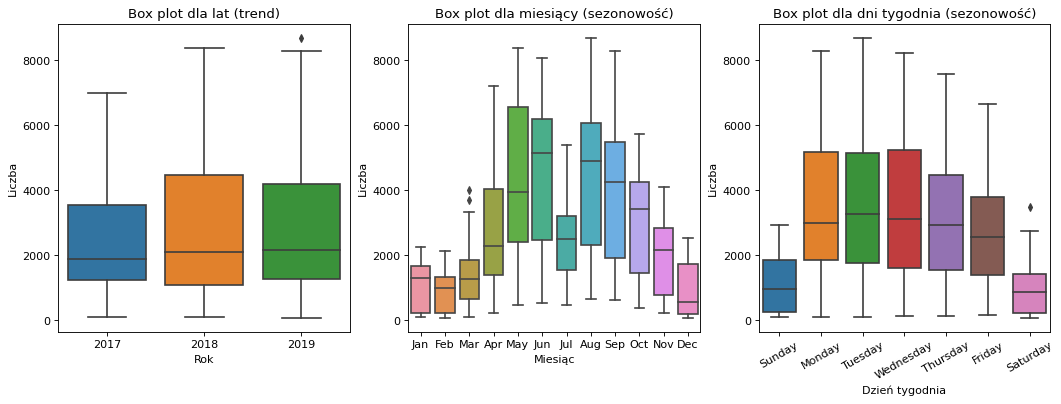

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=80)
sns.boxplot(x='year', y='Volume', data=full_years, ax=axes[0]).set(
    xlabel='Rok',
    ylabel='Liczba'
)

axes[0].set_title('Box plot dla lat (trend)')
sns.boxplot(x='month', y='Volume', data=full_years, ax=axes[1]).set(
    xlabel='Miesiąc',
    ylabel='Liczba'
)

axes[1].set_title('Box plot dla miesiący (sezonowość)')
sns.boxplot(x='weekday', y='Volume', data=full_years, ax=axes[2]).set(
    xlabel='Dzień tygodnia',
    ylabel='Liczba'
)

axes[2].set_title('Box plot dla dni tygodnia (sezonowość)')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=30)
plt.show()

In [18]:
holidays_Norway = holidays.NO()
def get_holiday(row):
    holidays = holidays_Norway.get(row['Date'])
    if holidays == None:
        return np.NaN

    # Søndag, czyli niedziela jest traktowana jako święto - usuwamy to święto
    elif holidays != 'Søndag':

        # Usunięcie niedzieli nakładającej się z innymi świętami
        if 'Søndag' in holidays:
            holidays = holidays.replace('Søndag', '')
            holidays = holidays.replace(',', '')
            holidays = holidays.lstrip().rstrip()
            return holidays
        else:
            return holidays
    else:
        return np.NaN
full_years['Holiday'] = full_years.apply(get_holiday, axis=1)
print('Unikalne święta:')
print(full_years['Holiday'].value_counts())
full_years

Unikalne święta:
Første nyttårsdag        3
Skjærtorsdag             3
Langfredag               3
Første påskedag          3
Andre påskedag           3
Arbeidernes dag          3
Grunnlovsdag             3
Kristi himmelfartsdag    3
Første juledag           3
Andre juledag            3
Første pinsedag          2
Andre pinsedag           2
Name: Holiday, dtype: int64


,Date,Volume,Rain,Temp,year,month,weekday,Holiday
45,2017-01-01,183.0,0.0,1.1,2017,Jan,Sunday,Første nyttårsdag
46,2017-01-02,1752.0,0.0,-2.8,2017,Jan,Monday,NaN
47,2017-01-03,1956.0,0.0,-2.5,2017,Jan,Tuesday,NaN
48,2017-01-04,1854.0,0.0,-3.1,2017,Jan,Wednesday,NaN
49,2017-01-05,1113.0,0.0,-10.1,2017,Jan,Thursday,NaN
...,...,...,...,...,...,...,...,...
1127,2019-12-27,342.0,0.0,-4.9,2019,Dec,Friday,NaN
1128,2019-12-28,63.0,0.0,-1.2,2019,Dec,Saturday,NaN
1129,2019-12-29,126.0,5.9,4.4,2019,Dec,Sunday,NaN
1130,2019-12-30,558.0,0.0,5.5,2019,Dec,Monday,NaN


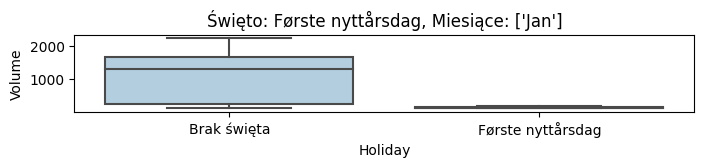

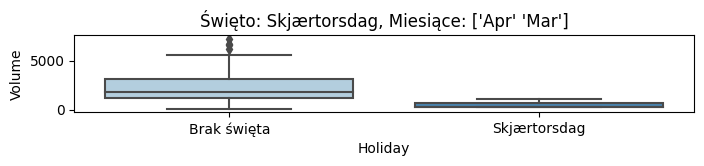

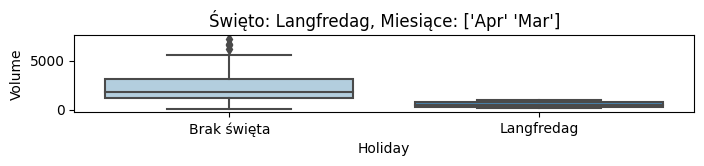

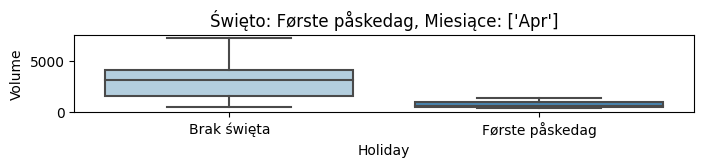

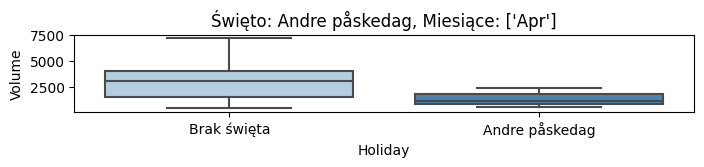

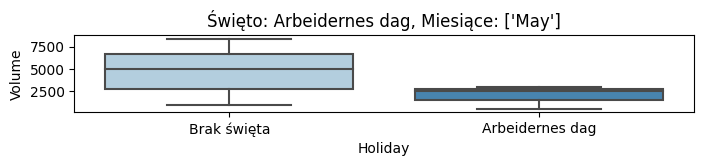

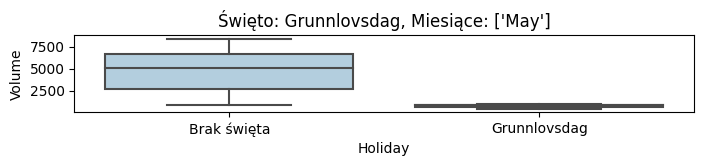

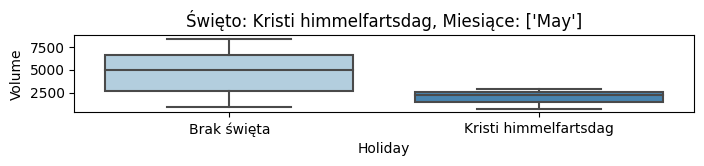

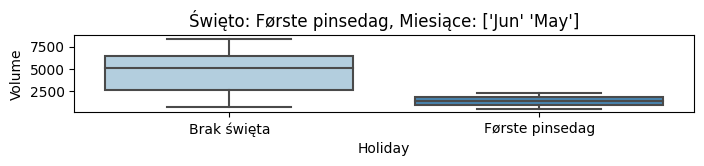

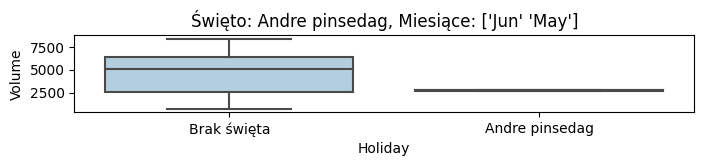

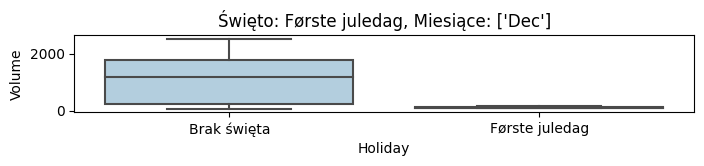

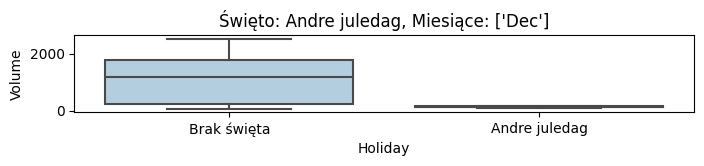

In [19]:
for unique_holiday in full_years['Holiday'].dropna().unique():

    # Filtrowanie miesięcy, w których to święto wystąpiło, usunięcie innych świąt w tym samym okresie
    month_holiday = full_years.loc[full_years['Holiday']==unique_holiday, 'month'].unique()
    selected_holiday = full_years.loc[((full_years['month'].isin(month_holiday))&\
                                       (full_years['Holiday'].isin([np.NaN, unique_holiday]))),
                                        :].copy()
    selected_holiday['Holiday'].fillna('Brak święta', inplace=True)

    # Wizualizacja wykresu plotowego
    plt.figure(figsize=(8, 1))
    sns.boxplot(x=selected_holiday['Holiday'], y=selected_holiday['Volume'],
                palette="Blues", order=['Brak święta', unique_holiday])
    plt.title(f'Święto: {unique_holiday}, Miesiące: {month_holiday}')
    plt.show()

In [20]:
full_years.loc[~full_years['Holiday'].isnull(), 'Holiday'] = 1
full_years.fillna(0, inplace=True)
full_years

,Date,Volume,Rain,Temp,year,month,weekday,Holiday
45,2017-01-01,183.0,0.0,1.1,2017,Jan,Sunday,1
46,2017-01-02,1752.0,0.0,-2.8,2017,Jan,Monday,0
47,2017-01-03,1956.0,0.0,-2.5,2017,Jan,Tuesday,0
48,2017-01-04,1854.0,0.0,-3.1,2017,Jan,Wednesday,0
49,2017-01-05,1113.0,0.0,-10.1,2017,Jan,Thursday,0
...,...,...,...,...,...,...,...,...
1127,2019-12-27,342.0,0.0,-4.9,2019,Dec,Friday,0
1128,2019-12-28,63.0,0.0,-1.2,2019,Dec,Saturday,0
1129,2019-12-29,126.0,5.9,4.4,2019,Dec,Sunday,0
1130,2019-12-30,558.0,0.0,5.5,2019,Dec,Monday,0


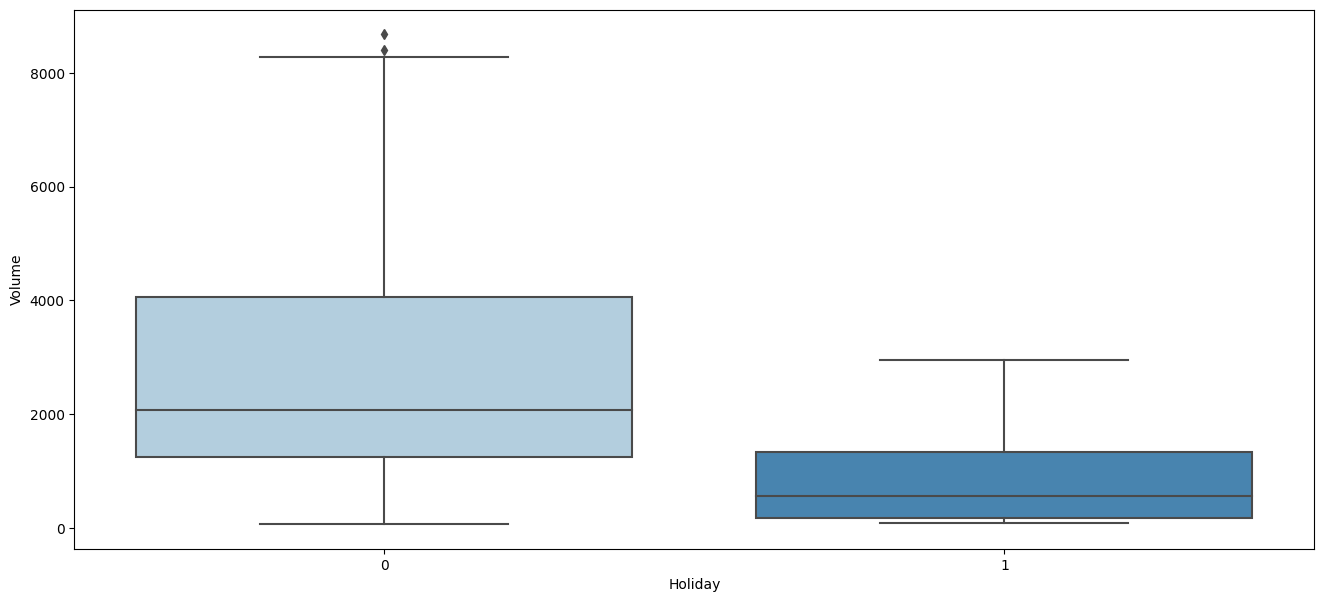

In [21]:
plt.figure(figsize=(16, 7))
sns.boxplot(x=full_years['Holiday'], y=full_years['Volume'], palette="Blues")
plt.show()

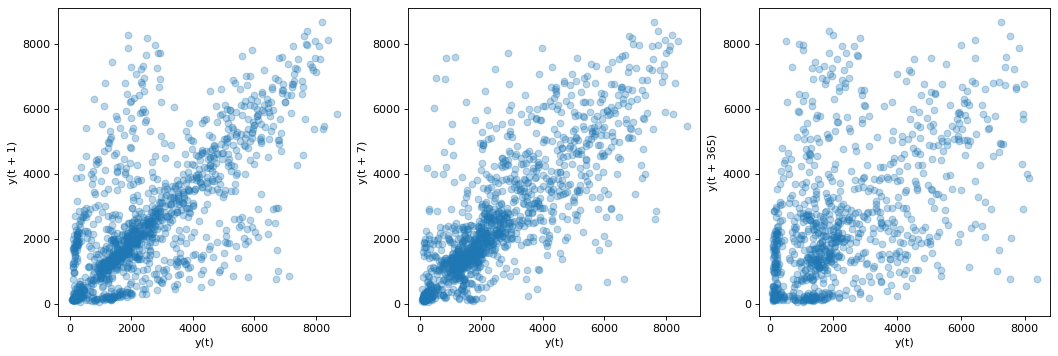

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=80)
pd.plotting.lag_plot(dataframe['Volume'], lag=1, ax=axes[0], alpha=0.3)
pd.plotting.lag_plot(dataframe['Volume'], lag=7, ax=axes[1], alpha=0.3)
pd.plotting.lag_plot(dataframe['Volume'], lag=365, ax=axes[2], alpha=0.3)
plt.show()

##### Jeśli na wykresie rozproszenia zauważalny jest jakikolwiek wzorzec, wówczas możemy sądzić, że szereg jest autoskorelowany. Jeśli punkty układają się w sposób losowy, wówczas będzie przypadkowym białym szumem.

### Wpływ pogody na liczbę rowerzystów

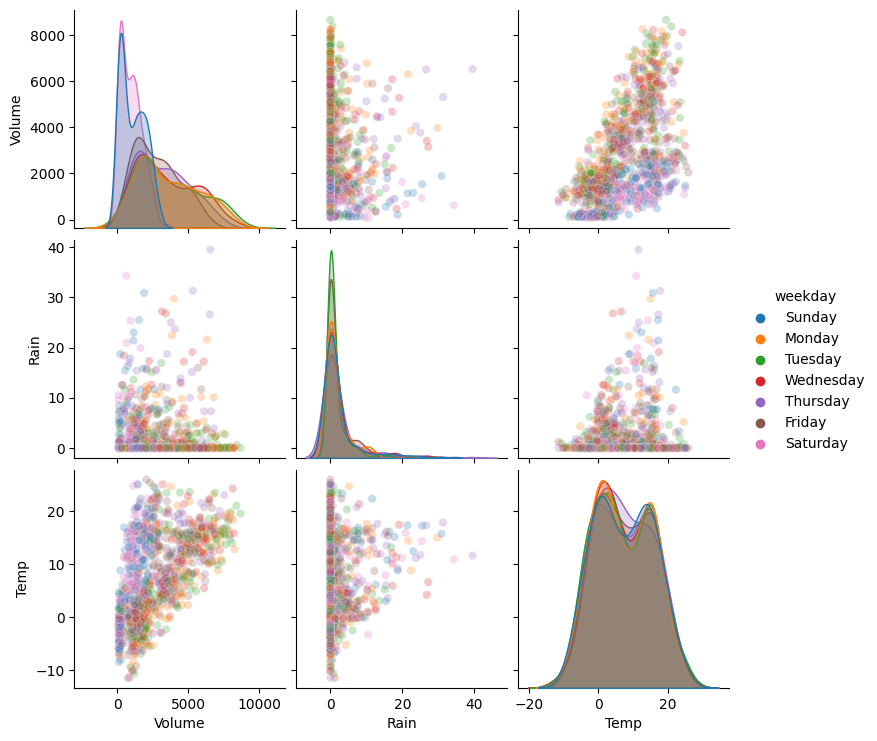

In [23]:
sns.pairplot(full_years[['Volume', 'Rain', 'Temp', 'weekday']], 
             hue='weekday', kind='scatter', plot_kws={'alpha':0.25})
plt.show()

# 20.3. Przygotowanie danych

In [24]:
dataframe

,Date,Volume,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8
...,...,...,...,...
1268,2020-05-16,2484.0,0.0,6.6
1269,2020-05-17,1509.0,0.0,9.1
1270,2020-05-18,5775.0,0.0,9.3
1271,2020-05-19,6741.0,0.0,9.7


### Dodanie brakujących danych

##### Transformer AddMissingDates

In [25]:
class AddMissingDates(BaseEstimator, TransformerMixin):
    def __init__(self, date_column):
        self.date_column = date_column
        pass
    def fit(self, X, y = None ):
        return self
    def transform(self, X, y = None ):
        X_transformed = X.copy()

        # Ustawienie kolumny z czasem jako indeksu
        X_transformed = X_transformed.set_index(self.date_column)
        X_transformed.index = pd.to_datetime(X_transformed.index)

        # Dodanie brakujących
        new_idx = pd.date_range(X_transformed.index.min(), X_transformed.index.max())
        X_transformed = X_transformed.reindex(new_idx)
        return X_transformed


##### Pipeline z Transformerem AddMissingDates

In [26]:
steps = [('add_missing_dates', 
          AddMissingDates(date_column='Date'))]

data_preparation_pipeline = Pipeline(steps = steps)
dataframe_prepared = data_preparation_pipeline.fit_transform(dataframe)
dataframe_prepared

,Volume,Rain,Temp
2016-11-17,933.0,9.0,2.1
2016-11-18,1197.0,6.7,3.9
2016-11-19,243.0,5.4,2.0
2016-11-20,234.0,3.9,2.8
2016-11-21,2148.0,7.3,2.8
...,...,...,...
2020-05-16,2484.0,0.0,6.6
2020-05-17,1509.0,0.0,9.1
2020-05-18,5775.0,0.0,9.3
2020-05-19,6741.0,0.0,9.7


In [27]:
dataframe_prepared.loc[dataframe_prepared.index=='2017-10-16',:]

,Volume,Rain,Temp
2017-10-16,NaN,NaN,NaN


### Uzupełnienie wartości brakujących

##### Transformer FillMissings

In [28]:
class FillMissings(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None ):
        return self

    def transform(self, X, y = None ):
        X_transformed = X.copy()

        # Uzupełnienie brakujących wartości dla liczby wypożyczonych rowerów
        X_transformed.loc[X_transformed['Volume'].isnull(), 
                          'Volume'] = X_transformed['Volume'].shift(7)

        # Uzupełnienie brakujących wartości dla zmiennych pogodowych
        X_transformed.loc[X_transformed['Rain'].isnull(), 
                          'Rain'] = X_transformed['Rain'].shift(1)
        X_transformed.loc[X_transformed['Temp'].isnull(), 
                          'Temp'] = X_transformed['Temp'].shift(1)

        return X_transformed

In [29]:
steps = [
    ('add_missing_dates', AddMissingDates(date_column='Date')),
    ('fill_missing_values', FillMissings())
]
data_preparation_pipeline = Pipeline(steps = steps)
dataframe_prepared = data_preparation_pipeline.fit_transform(dataframe)
dataframe_prepared

,Volume,Rain,Temp
2016-11-17,933.0,9.0,2.1
2016-11-18,1197.0,6.7,3.9
2016-11-19,243.0,5.4,2.0
2016-11-20,234.0,3.9,2.8
2016-11-21,2148.0,7.3,2.8
...,...,...,...
2020-05-16,2484.0,0.0,6.6
2020-05-17,1509.0,0.0,9.1
2020-05-18,5775.0,0.0,9.3
2020-05-19,6741.0,0.0,9.7


In [30]:
dataframe_prepared.loc[dataframe_prepared.index=='2017-10-16',:]

,Volume,Rain,Temp
2017-10-16,4947.0,0.0,9.6


### Feature Engineering - Inżynieria cech

##### Transformer FeatureEngineeringTransformer

##### Robimy prognozę dla 2020-05-20. Prognoza dla tego dnia musi być wykonana tydzień wcześniej, zatem ostatnią znaną wartością wypożyczonych rowerów będzie wartość z dnia 2020-05-13 – zmienna Volume_lag_7. Na podstawie Volume_lag_7 tworzymy opóźnione wartości, czyli ile wypożyczeń było dzień wcześniej, dwa dni wcześniej, aż do dwóch tygodni wcześniej.

##### Następnym krokiem po dodaniu surowych wartości opóźnionych jest dodanie kroczących statystyk, czyli dla przesuwanego okna wyliczamy różne statystyki. Dla okien o szerokości 7 oraz 14 dni wyliczamy średnią, odchylenie standardowe oraz wartość minimalną i maksymalną.

##### Dodajemy zmienną z rokiem, ponieważ widoczny w danych jest trend pomiędzy 2017 a 2018 rokiem. Dodajemy również święta, jednak w tym przypadku uogólniamy święta do informacji, czy było święto czy nie. Na koniec usuwamy obserwacje z brakującymi wartościami powstałymi przez to, że są to pierwsze obserwacje i nie ma skąd wziąć dla nich przeszłości.

In [31]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        def encode_time(X, col, max_val):
            X[col + '_sin'] = np.sin(2 * np.pi * X[col]/max_val)
            X[col + '_cos'] = np.cos(2 * np.pi * X[col]/max_val)
            X.drop(col, axis='columns', inplace=True)
            return X
        def get_holiday(row):
            holidays = holidays_Norway.get(row['Date'])
            if holidays == None:
                return 0

            # Søndag, czyli niedziela jest traktowana jako święto - usuwamy to święto
            elif holidays != 'Søndag':

                # Usunięcie niedzieli nakładającej się z innymi świętami
                if 'Søndag' in holidays:
                    holidays = holidays.replace('Søndag', '')
                    holidays = holidays.replace(',', '')
                    holidays = holidays.lstrip().rstrip()
                    return 1
                else:
                    return 1
            else:
                return 0
        X_transformed = X.copy()

        # Zmienne z przeszłości - możemy stosować wartości maksymalnie sprzed tygodnia
        # Dlatego najświeższą wartością z przeszłości dla wypożyczonych rowerów będzie 
        # wartość sprzed tygodnia
        X_transformed['Volume_lag_7W'] = X_transformed['Volume'].shift(7)

        # Opóźnione wartości
        for lag in range(1, 15):
            X_transformed[f'Volume_lag_{lag+7}W'] = X_transformed['Volume_lag_7W'].shift(lag)

        # Kroczące statystyki
        for window in [7, 14]:
            X_transformed[f'Volume_window_{window}_mean'] = X_transformed['Volume_lag_7W'].rolling(window=window).mean()
            X_transformed[f'Volume_window_{window}_std'] = X_transformed['Volume_lag_7W'].rolling(window=window).std()
            X_transformed[f'Volume_window_{window}_min'] = X_transformed['Volume_lag_7W'].rolling(window=window).min()
            X_transformed[f'Volume_window_{window}_max'] = X_transformed['Volume_lag_7W'].rolling(window=window).max()

        # Dzień w roku - sezonowość
        X_transformed['day_of_year'] = X_transformed.index.dayofyear
        X_transformed = encode_time(X_transformed, 'day_of_year', 366)

        # Dzień w tygodniu - sezonowość
        X_transformed['weekday'] = X_transformed.index.weekday
        X_transformed = encode_time(X_transformed, 'weekday', 7)

        # Rok - należy rozróżnić wartości z 2017 roku, wtedy średnio było mniej wypożyczeń
        X_transformed['year'] = X_transformed.index.year

        # Dodanie święta
        X_transformed['Date'] = X_transformed.index
        X_transformed['Holiday'] = X_transformed.apply(get_holiday, axis=1)
        X_transformed.drop(['Date'], axis=1, inplace=True)

        # Usunięcie wierszy z brakującymi danymi
        X_transformed.dropna(inplace=True)
        return X_transformed

##### Do Pipeline dodajemy Transformer FeatureEngineeringTransformer, który tworzy nowe cechy dla X.

In [32]:
steps = [
    ('add_missing_dates', AddMissingDates(date_column='Date')),
    ('fill_missing_values', FillMissings()),
    ('feature_engineering', FeatureEngineeringTransformer())
]

data_preparation_pipeline = Pipeline(steps = steps)
dataframe_prepared = data_preparation_pipeline.fit_transform(dataframe)
dataframe_prepared

,Volume,Rain,Temp,Volume_lag_7W,Volume_lag_8W,Volume_lag_9W,Volume_lag_10W,Volume_lag_11W,Volume_lag_12W,Volume_lag_13W,...,Volume_window_14_mean,Volume_window_14_std,Volume_window_14_min,Volume_window_14_max,day_of_year_sin,day_of_year_cos,weekday_sin,weekday_cos,year,Holiday
2016-12-08,1743.0,10.3,5.7,1620.0,1908.0,1884.0,2175.0,396.0,384.0,1638.0,...,1407.642857,761.568483,234.0,2175.0,-0.384665,0.923056,0.433884,-0.900969,2016,0
2016-12-09,1608.0,0.0,3.4,1464.0,1620.0,1908.0,1884.0,2175.0,396.0,384.0,...,1426.714286,759.227282,234.0,2175.0,-0.368763,0.929523,-0.433884,-0.900969,2016,0
2016-12-10,261.0,0.3,2.1,213.0,1464.0,1620.0,1908.0,1884.0,2175.0,396.0,...,1424.571429,762.858865,213.0,2175.0,-0.352752,0.935717,-0.974928,-0.222521,2016,0
2016-12-11,354.0,3.4,0.5,246.0,213.0,1464.0,1620.0,1908.0,1884.0,2175.0,...,1425.428571,761.423638,213.0,2175.0,-0.336637,0.941634,-0.781831,0.623490,2016,0
2016-12-12,1941.0,0.0,-1.1,2079.0,246.0,213.0,1464.0,1620.0,1908.0,1884.0,...,1420.500000,756.594775,213.0,2175.0,-0.320423,0.947274,0.000000,1.000000,2016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-16,2484.0,0.0,6.6,3681.0,4884.0,5649.0,6126.0,5853.0,4962.0,3072.0,...,4090.500000,1326.470200,2049.0,6126.0,0.710135,-0.704066,-0.974928,-0.222521,2020,0
2020-05-17,1509.0,0.0,9.1,1320.0,3681.0,4884.0,5649.0,6126.0,5853.0,4962.0,...,3925.928571,1517.910429,1320.0,6126.0,0.697944,-0.716152,-0.781831,0.623490,2020,1
2020-05-18,5775.0,0.0,9.3,5304.0,1320.0,3681.0,4884.0,5649.0,6126.0,5853.0,...,4157.571429,1457.674160,1320.0,6126.0,0.685548,-0.728028,0.000000,1.000000,2020,0
2020-05-19,6741.0,0.0,9.7,4881.0,5304.0,1320.0,3681.0,4884.0,5649.0,6126.0,...,4271.571429,1446.550417,1320.0,6126.0,0.672949,-0.739689,0.781831,0.623490,2020,0


### Podział danych na X i y

In [33]:
X = dataframe_prepared.drop(['Volume'], axis=1)
y = dataframe_prepared['Volume']

### Podział danych na zbiór treningowy i testowy

In [34]:
first_test_date = dt.datetime.strptime('2020-01-01', '%Y-%m-%d')
X_train, y_train = X[X.index<first_test_date].copy(), y[y.index<first_test_date].copy()
X_test, y_test = X[X.index>=first_test_date].copy(), y[y.index>=first_test_date].copy()

### Selekcja zmiennych

##### My w tej części skorzystamy z metody własnej Random Forest, która jest Feature Importance – ważnością cech. 

##### Część ze zmiennych niesie podobną informację, na przykład wartości opóźnione dla różnego laga. Takie zmienne umieścimy do jednego koszyka (busket) i wybierzemy jedną z największą ważnością.

In [35]:
importances = RandomForestRegressor(n_estimators=1000, max_depth=20, 
                                    n_jobs=-1).fit(X_train, y_train).feature_importances_
features = pd.concat([pd.DataFrame(X_train.columns, columns=['feat']),
                      pd.DataFrame(importances, columns=['importance'])], 
                      axis=1).sort_values(by='importance', ascending=False)
features = features[features['importance']>0.0075]
features.loc[features['feat'].str.contains('Volume_lag_'), 'Busket'] = 'lag'
features.loc[features['feat'].str.contains('mean'), 'Busket'] = 'mean'
features.loc[features['feat'].str.contains('std'), 'Busket'] = 'std'
features.loc[features['feat'].str.contains('min'), 'Busket'] = 'min'
features.loc[features['feat'].str.contains('max'), 'Busket'] = 'max'
display(features)

features = features[(~features.duplicated(subset='Busket', keep='first'))|(features['Busket'].isnull())]
features = list(features['feat'].values)

print(f'Liczba zmiennych: {len(features)}')
print(f'Zmienne: {features}')

,feat,importance,Busket
2,Volume_lag_7W,0.634775,lag
9,Volume_lag_14W,0.065620,lag
1,Temp,0.032623,NaN
26,day_of_year_cos,0.024978,NaN
25,day_of_year_sin,0.024798,NaN
20,Volume_window_7_max,0.024143,max
30,Holiday,0.017333,NaN
24,Volume_window_14_max,0.017301,max
16,Volume_lag_21W,0.015735,lag
22,Volume_window_14_std,0.013995,std


Liczba zmiennych: 10
Zmienne: ['Volume_lag_7W', 'Temp', 'day_of_year_cos', 'day_of_year_sin', 'Volume_window_7_max', 'Holiday', 'Volume_window_14_std', 'Rain', 'weekday_sin', 'Volume_window_14_min']


##### Mamy już wyselekcjonowany zbiór cech, zmniejszyliśmy go o ponad 2/3. Wyfiltrujmy z X tylko te zmienne, które wybrano podczas selekcji cech.

In [36]:
X_train = X_train[features]
X_test = X_test[features]

# 20.4. Modelowanie i ewaluacja

### Model podstawowy – Baseline

##### To taki model, do którego porownujemy nasze modele - może być to prosta statystyka, jak średnia, bądź coś bardziej zaawansowanego, ale nadal podstawowego - u nas to będzie średnia z wartości, która była rok temu oraz tydzień wcześniej.

In [37]:
prediction_baseline = y.copy()
prediction_baseline = np.round((prediction_baseline.shift(367) + prediction_baseline.shift(7)) / 2)
prediction_baseline.dropna(inplace=True)
prediction_baseline = prediction_baseline[prediction_baseline.index>=first_test_date]
prediction_baseline

2020-01-01     144.0
2020-01-02     219.0
2020-01-03     278.0
2020-01-04      87.0
2020-01-05     134.0
               ...  
2020-05-16    3192.0
2020-05-17    1744.0
2020-05-18    6190.0
2020-05-19    6130.0
2020-05-20    6510.0
Name: Volume, Length: 141, dtype: float64

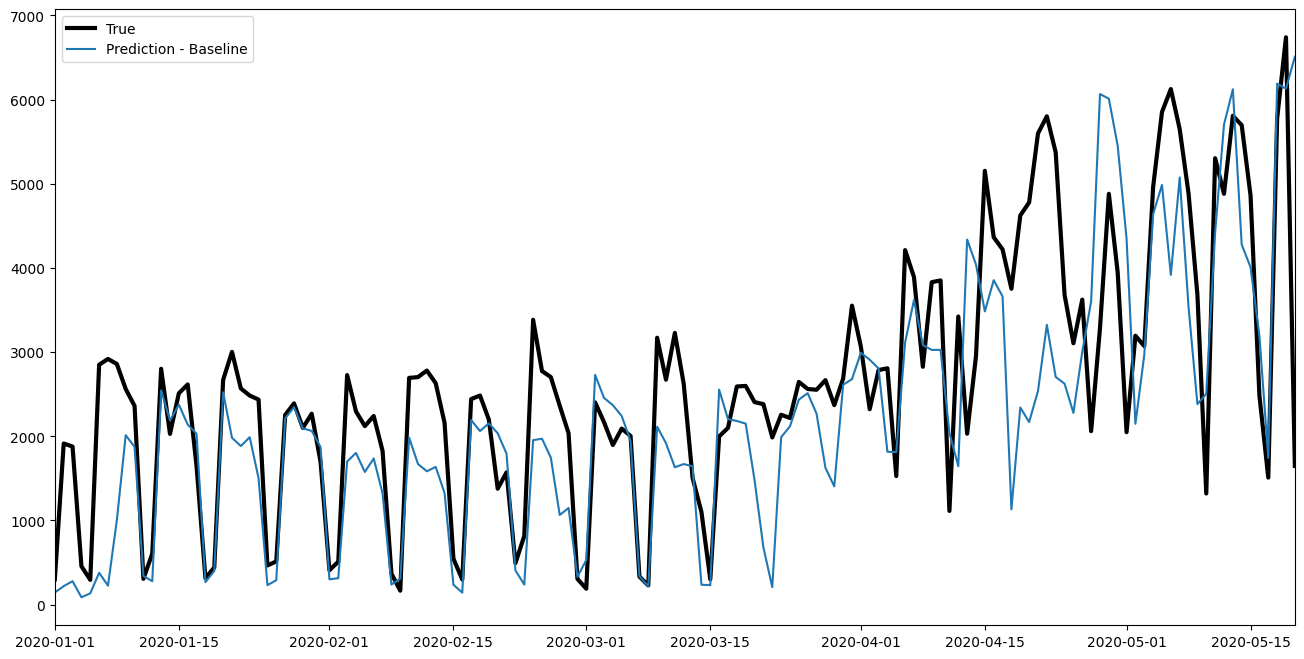

In [38]:
def plot_prediction_vs_true(yhat_list, yhat_names, ytest):
    plt.figure(figsize=(16, 8), dpi=100)
    plt.plot(ytest, color='black', label='True', linewidth=3)
    for yhat, yname in zip(yhat_list, yhat_names):
        plt.plot(yhat, label=f'Prediction - {yname}')
    plt.xlim([ytest.index.min(), ytest.index.max()])
    plt.legend(loc='upper left')
    plt.show()

plot_prediction_vs_true(yhat_list=[prediction_baseline],
                        yhat_names=['Baseline'],
                        ytest=y_test)


##### Funkcja, która oblicza koszt spowodowany złą prognozą:

In [39]:
def Cost(y_true, y_pred):
        def apply_cost(x):
            if x < 0:
                x = np.abs(x)*10
            return x
        y_pred = np.round(y_pred)
        cost = y_pred - y_true
        cost = cost.apply(apply_cost)
        return np.sum(cost)

In [40]:
def model_evaluation(yhat, ytest):
    def fit_scatter_plot(yhat, ytest):
        xmin = ytest.min()
        xmax = ytest.max()
        plt.scatter(x = yhat, y = ytest, alpha=0.25)
        x_line = np.linspace(xmin, xmax, 10)
        y_line = x_line
        plt.plot(x_line, y_line, 'r--')
        plt.xlabel('Predykcja')
        plt.ylabel('Wartość Prawdziwa')
        plt.title(f'Wykres predykcji względem wartości prawdziwych - Test set')
    def plot_of_residuals(yhat, ytest):
        errors = yhat - ytest
        plt.scatter(x = ytest, y = errors, alpha=0.25)
        plt.axhline(0, color="r", linestyle="--")
        plt.xlabel('Wartość Prawdziwa')
        plt.ylabel('Reszta')
        plt.title(f'Wykres reszt - Test set')
    def hist_of_residuals(yhat, ytest):
        errors = yhat - ytest
        plt.hist(errors, bins = 100)
        plt.axvline(errors.mean(), color='k', linestyle='dashed', linewidth=1)
        plt.title(f'Histogram reszt - Test set')
    fig = plt.figure(figsize = (18, 6))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax = fig.add_subplot(1, 3, 1)
    fit_scatter_plot(yhat, ytest)
    ax = fig.add_subplot(1, 3, 2)
    plot_of_residuals(yhat, ytest)
    ax = fig.add_subplot(1, 3, 3)
    hist_of_residuals(yhat, ytest)
    plt.show()

    print(f'RMSE Test: {sqrt(mean_squared_error(ytest, yhat))}')
    print(f'Pomniejszony zysk: {Cost(ytest, yhat)}')


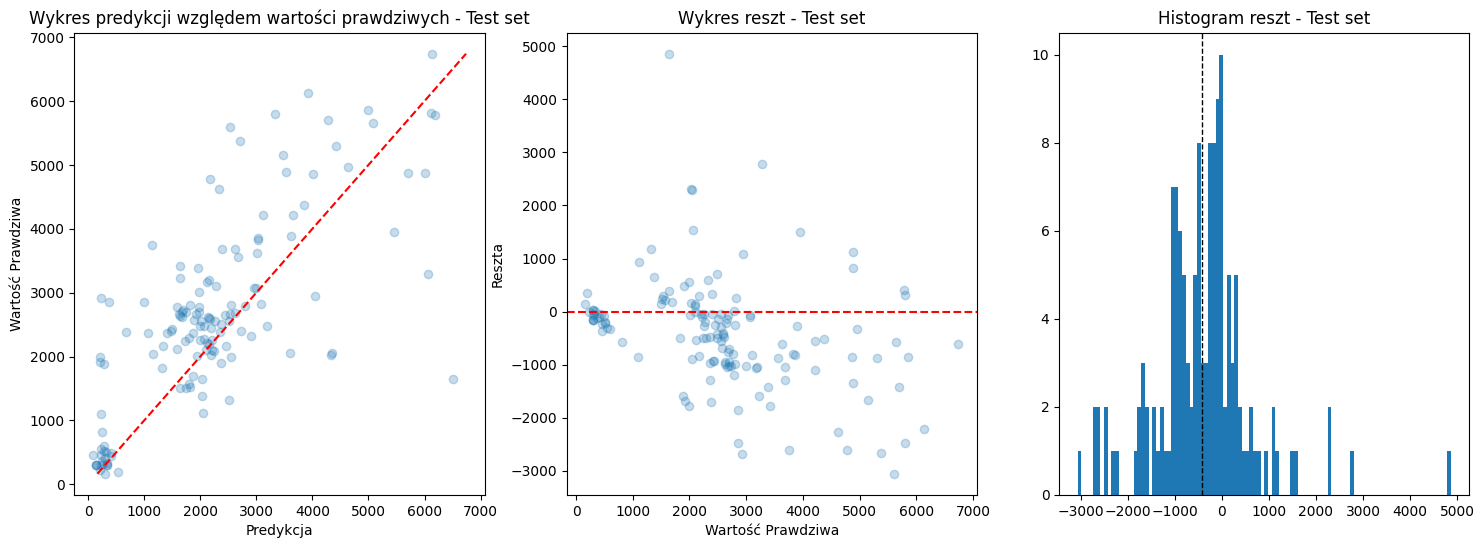

RMSE Test: 1127.9512337932003
Pomniejszony zysk: 884447.0


In [41]:
model_evaluation(yhat=prediction_baseline, ytest=y_test)

### Drzewo decyzyjne

##### Własny ‘scorer’, który postaramy się minimalizować naszymi modelami. Będzie on oparty o funkcję, która oblicza koszt powstały przez błędną prognozę.

In [42]:
cost_scorer = make_scorer(Cost, greater_is_better=False)

##### Do podziału na zbiory walidacyjne stosujemy TimeSeriesSplit

In [43]:
tree = DecisionTreeRegressor(random_state=2022)
params = {'max_depth': [2, 3, 5, 7, 10],
          'min_samples_leaf': [2, 3, 5, 7, 10]}
tree_gridsearch = GridSearchCV(tree,
                               params,
                               scoring=cost_scorer,
                               cv=TimeSeriesSplit(n_splits=5).split(X_train),
                               verbose=10,
                               n_jobs=-1)
tree_gridsearch.fit(X_train, y_train)
print('\nNajlepsze hiperparametry:', tree_gridsearch.best_params_)
tree_model = tree_gridsearch.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits

Najlepsze hiperparametry: {'max_depth': 5, 'min_samples_leaf': 2}


In [44]:
prediction_tree = tree_model.predict(X_test)
prediction_tree = pd.Series(prediction_tree, index=y_test.index)
prediction_tree

2020-01-01     195.750000
2020-01-02    1894.000000
2020-01-03    1894.000000
2020-01-04     227.720339
2020-01-05     227.720339
                 ...     
2020-05-16    3191.152941
2020-05-17    1650.627273
2020-05-18    4062.000000
2020-05-19    4135.896000
2020-05-20    5970.966667
Length: 141, dtype: float64

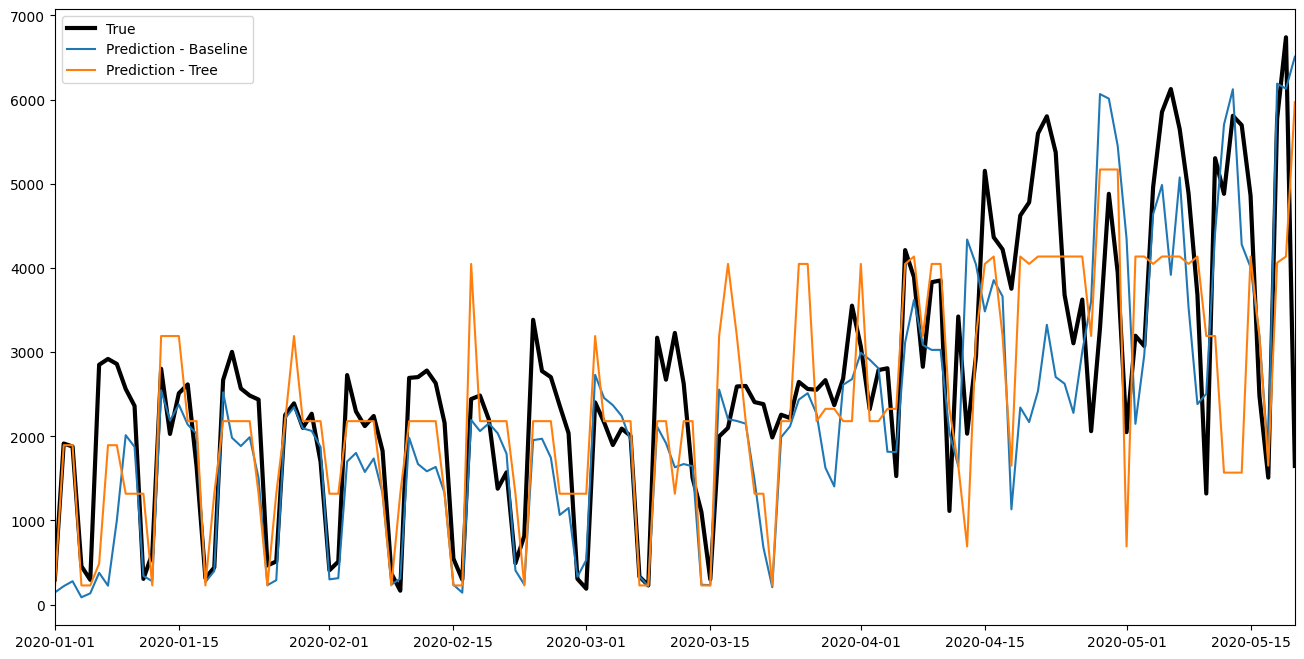

In [45]:
plot_prediction_vs_true(yhat_list=[prediction_baseline, prediction_tree],
                        yhat_names=['Baseline', 'Tree'],
                        ytest=y_test)

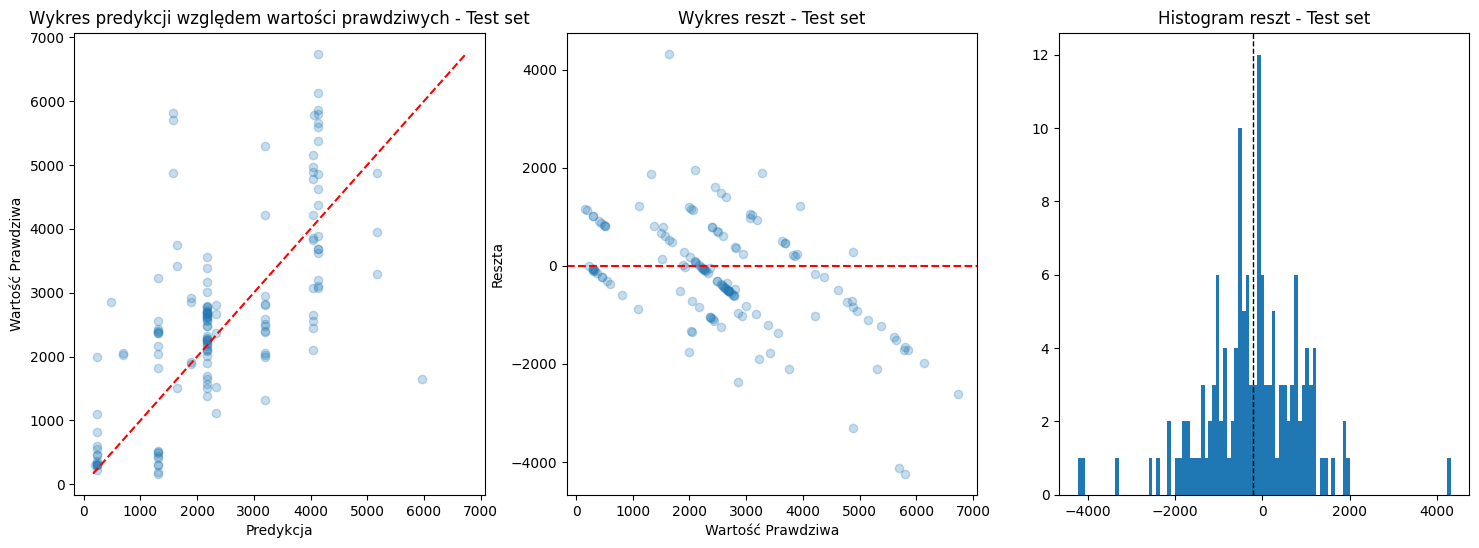

RMSE Test: 1156.6176132425553
Pomniejszony zysk: 793342.0


In [46]:
model_evaluation(yhat=prediction_tree, ytest=y_test)

### Las losowy (Random Forest)

In [47]:
forest = RandomForestRegressor(n_estimators=1000, random_state=2022)
params = {'max_depth': [2, 3, 5, 10],
          'min_samples_leaf': [3, 5, 10, 15]}
forest_gridsearch = GridSearchCV(forest,
                                 params,
                                 scoring=cost_scorer,
                                 cv=TimeSeriesSplit(n_splits=5).split(X_train),
                                 verbose=10,
                                 n_jobs=-1)
forest_gridsearch.fit(X_train, y_train)
print('\nNajlepsze hiperparametry:', forest_gridsearch.best_params_)
forest_model = forest_gridsearch.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Najlepsze hiperparametry: {'max_depth': 10, 'min_samples_leaf': 3}


In [48]:
prediction_forest = forest_model.predict(X_test)
prediction_forest = pd.Series(prediction_forest, index=y_test.index)
prediction_forest

2020-01-01     493.284280
2020-01-02    1665.403369
2020-01-03    1703.355302
2020-01-04     203.333597
2020-01-05     193.415298
                 ...     
2020-05-16    3158.255300
2020-05-17    1710.055081
2020-05-18    4817.663156
2020-05-19    4853.724360
2020-05-20    5673.537947
Length: 141, dtype: float64

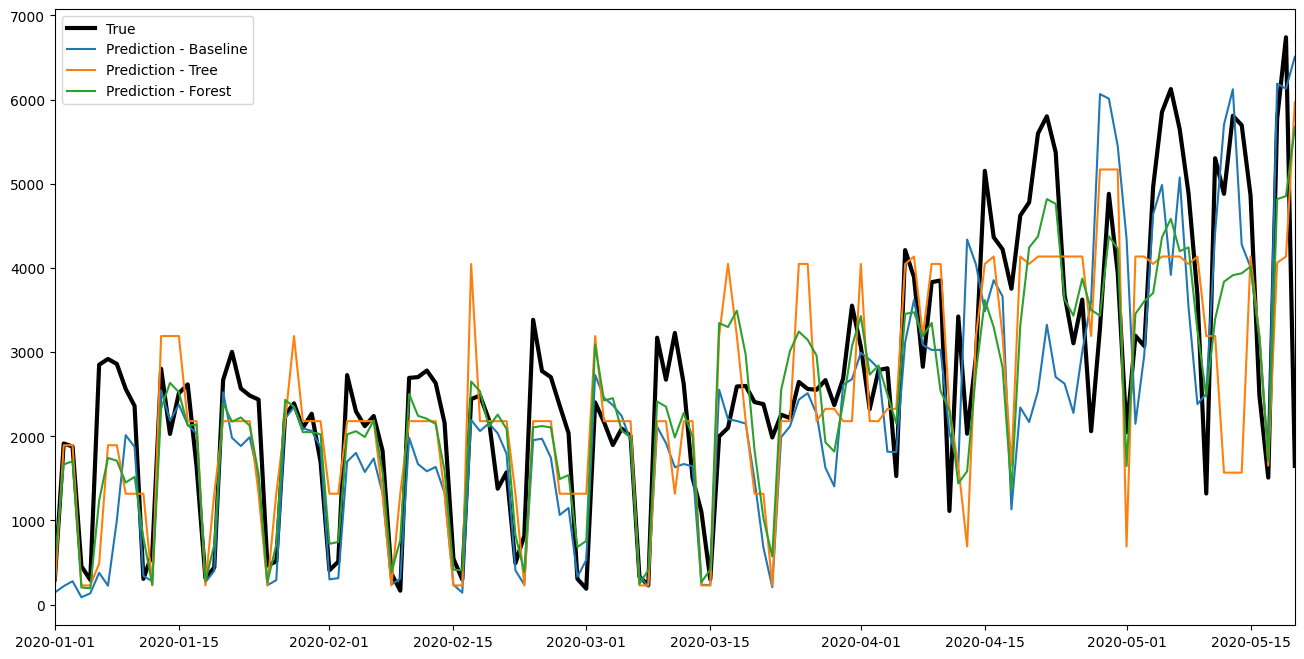

In [49]:
plot_prediction_vs_true(yhat_list=[prediction_baseline, prediction_tree, prediction_forest],
                        yhat_names=['Baseline', 'Tree', 'Forest'],
                        ytest=y_test)

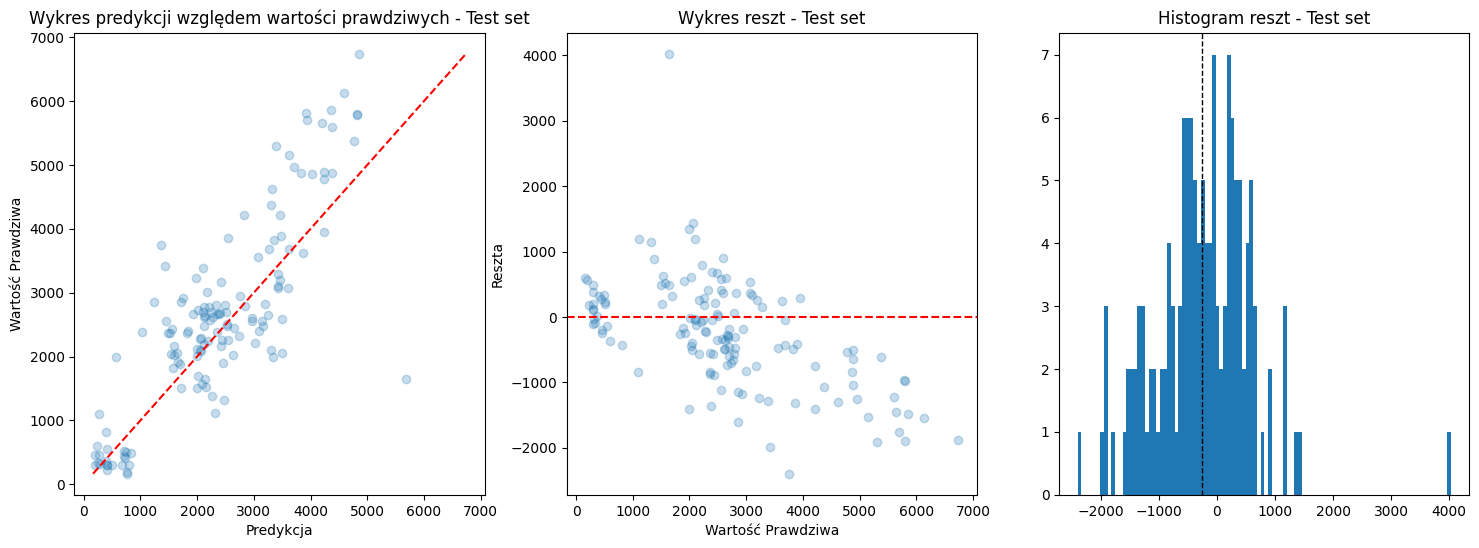

RMSE Test: 866.5100108286892
Pomniejszony zysk: 663147.0


In [50]:
model_evaluation(yhat=prediction_forest, ytest=y_test)

### Interpretacja modelu

##### Jaki wpływ mają zmienne na wartość końcowej prognozy? Do tego wykorzystamy wartości Shapleya.

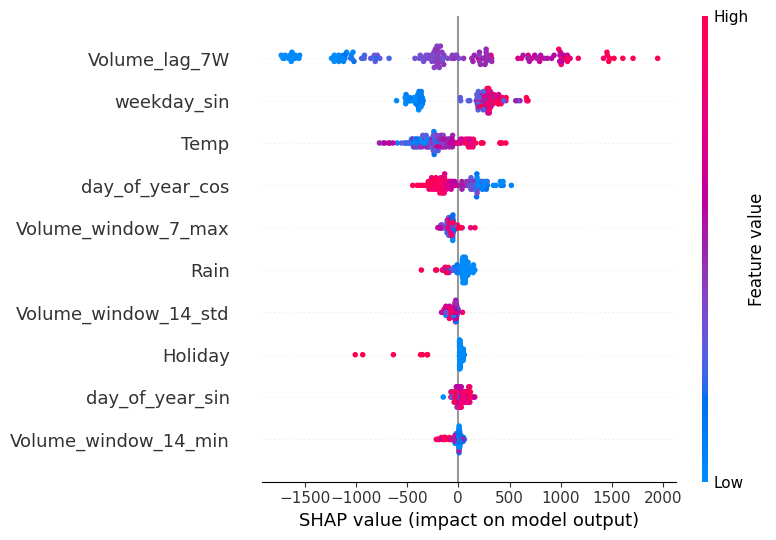

In [51]:
explainer = shap.TreeExplainer(forest_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

##### Spójrzmy na temperaturę, wyższe wartości mają dodatni wpływ na prognozę. Inaczej ma się to do deszczu, gdzie wyższe wartości mają negatywny wpływ na prognozę. W dodatku zauważyć możemy, że większy wpływ na wartość końcową ma temperatura.

# 20.5. Wdrożenie

##### Wykorzystując bibliotekę joblib, możemy serializować modele i je zapisać. Taki model może być wykorzystany w aplikacji, dashbordzie, czy w systemie, który przesyła prognozę do wewnętrzego systemu firmy.

In [52]:
joblib.dump(forest_model, 'forest_model.pkl')

['forest_model.pkl']